In [1]:
import numpy as np
from numpy.linalg import inv
from numpy import linalg as LA
import matplotlib.pyplot as plt
import proyecciones as pro
import time

# Parámetros

![SmartSelect_20231124_112800_Samsung%20Notes.png](attachment:SmartSelect_20231124_112800_Samsung%20Notes.png)

In [274]:
# Seteamos los parámetros:
N, M = 2, 5  # Son 2 tecnologías, 10 escenarios.

if 1:
    r=1
else:
    r=0

# Probabilidades:
Sigma = np.ones((1,M)) 
Sigma /= Sigma.shape[1] 

# Parámetros funciones:
I    = 50000.0 * (np.ones((N, 1)) + r*np.random.rand(N,1))
MC   = np.array([np.diag(1000*np.ones(N)+r*90*np.random.rand(N)) for m in range(M)])
VOLL = 1000.0
D    = 100.0*(1+r*np.random.rand(1,M))

frobenius_norm_of_MC = np.array([LA.norm(np.einsum('i,ikl->ikl',Sigma[0],0.01*MC)[xi], 'fro') for xi in range(M)]).sum()

# variables
x1     = np.random.randint(0,10, size=(N, 1))+0.0
x1_NA  = np.random.randint(0,10, size=(N, M))+0.0
x2     = np.random.randint(0,10, size=(N, M))+0.0
x3     = np.random.randint(0,10, size=(1, M))+0.0


# Consideremos funciones Phi_i de la forma:
# 
#     Phi_i(x_i) = 1/2 x_i.T*Q_i*x_i + B_i.T * x_i + C_i
#

def Phi_1(x1, Q_1 = np.zeros((N,N)), B_1 = I, C_1 = 0.0 ):
    return 0.5*np.einsum('ij,ji -> i', x1.T,np.dot(Q_1,x1))[:,np.newaxis]+np.dot(x1.T, B_1)+C_1

def Phi_2_xi(x2, Q_2 = 0.01*MC, B_2 = np.zeros((N,M)), C_2 = np.zeros((M, 1))):
    return 0.5*np.einsum('ij,ji -> i', x2.T, np.einsum('ijk,ki -> ji', Q_2, x2))[:,np.newaxis]+np.einsum('ij,ji->i',x2.T,B_2)[:,np.newaxis]+C_2
    
def Phi_3_xi(x3, Q_3 = np.zeros((1,M)), B_3 = -VOLL*np.ones((1,M)), C_3 = VOLL*D ):
        return (0.5*x3*Q_3*x3+B_3*x3+C_3).T


def objective_function(x1, x2, x3, P = Sigma, NA = True):
    # 
    # NA = True, cumple la funcion que si se impuso 
    #      la condición de no anticipatividad para x1
    #      entonces, Phi_1(x1).shape == (M,1)
    if NA:
        return np.dot(P, Phi_1(x1) +Phi_2_xi(x2)+Phi_3_xi(x3))
    else:
        return Phi_1(x1)+ np.dot(P, Phi_2_xi(x2)+Phi_3_xi(x3))

    
def Grad_Phi_1(x1, Q_1 = np.zeros((N,N)), B_1 = I):
        return np.dot(Q_1,x1)+B_1

def Grad_Phi_2(x2, Q_2 = 0.01*MC, B_2 = np.zeros((N,M))):
        return np.einsum('ijk,ki->ji', Q_2, x2)+B_2

def Grad_Phi_3(x3, Q_3 = np.zeros((1,M)), B_3 = -VOLL*np.ones((1,M))):
        return Q_3*x3+B_3
    
def Grad_Phi(x1,x2,x3, P = Sigma):
        return Grad_Phi_1(x1), P*Grad_Phi_2(x2), P*Grad_Phi_3(x3)

In [275]:
print("Variables:")
print("x1:")
print(x1)
print("x1_NA:")
print(x1_NA)
print("x2:")
print(x2)
print("x3:")
print(x3)
print()
print()
print("Parámetros:")
print("Sigma:")
print(Sigma)
print("I:")
print(I)
print("MC:")
print(MC)
print("VOLL:")
print(VOLL)
print()
print()
print("Funciones Objetivos:")
print("Phi_1(x1):")
print(Phi_1(x1))
print("Phi_1(x1_NA):")
print(Phi_1(x1_NA))
print("Phi_2_xi(x2):")
print(Phi_2_xi(x2))
print("Phi_3_xi(x3):")
print(Phi_3_xi(x3))
print()
print()
print("Phi_1(x1)+lE_xi{Phi_2_xi(x2)}+lE_xi{Phi_3_xi(x3)}")
print(objective_function(x1,x2,x3, NA = False))
print("Phi_1(x1_NA)+lE_xi{Phi_2_xi(x2)}+lE_xi{Phi_3_xi(x3)}")
print(objective_function(x1_NA,x2,x3))
print()
print()
print("Gradientes:")
print("Grad_Phi_1(x1):")
print(Grad_Phi_1(x1))
print("Grad_Phi_1(x1_NA):")
print(Grad_Phi_1(x1_NA))
print("Grad_Phi_2_xi(x2):")
print(Grad_Phi_2(x2))
print("Grad_Phi_3_xi(x3):")
print(Grad_Phi_3(x3))
print("Grad_Phi(x1,x2,x3)")
print(Grad_Phi(x1,x2,x3))
print("Grad_Phi(x1_NA,x2,x3)")
print(Grad_Phi(x1_NA,x2,x3))

Variables:
x1:
[[2.]
 [9.]]
x1_NA:
[[7. 7. 5. 7. 1.]
 [3. 4. 2. 4. 9.]]
x2:
[[7. 8. 3. 8. 0.]
 [4. 7. 8. 1. 8.]]
x3:
[[9. 9. 7. 2. 9.]]


Parámetros:
Sigma:
[[0.2 0.2 0.2 0.2 0.2]]
I:
[[55821.05451402]
 [59979.15838254]]
MC:
[[[1064.0546617     0.        ]
  [   0.         1056.55519399]]

 [[1052.97675397    0.        ]
  [   0.         1049.42102676]]

 [[1087.61286013    0.        ]
  [   0.         1020.960568  ]]

 [[1000.95600222    0.        ]
  [   0.         1071.99735075]]

 [[1061.21018617    0.        ]
  [   0.         1083.72237111]]]
VOLL:
1000.0


Funciones Objetivos:
Phi_1(x1):
[[651454.5344709]]
Phi_1(x1_NA):
[[570684.85674579]
 [630664.01512832]
 [399063.5893352 ]
 [630664.01512832]
 [595633.47995688]]
Phi_2_xi(x2):
[[345.21780764]
 [594.06071283]
 [375.64996047]
 [325.66590746]
 [346.79115875]]
Phi_3_xi(x3):
[[117730.05880854]
 [116889.33137624]
 [ 99304.81869384]
 [152676.99734801]
 [153631.24381365]]


Phi_1(x1)+lE_xi{Phi_2_xi(x2)}+lE_xi{Phi_3_xi(x3)}
[[779898.501

# Davis_Yin

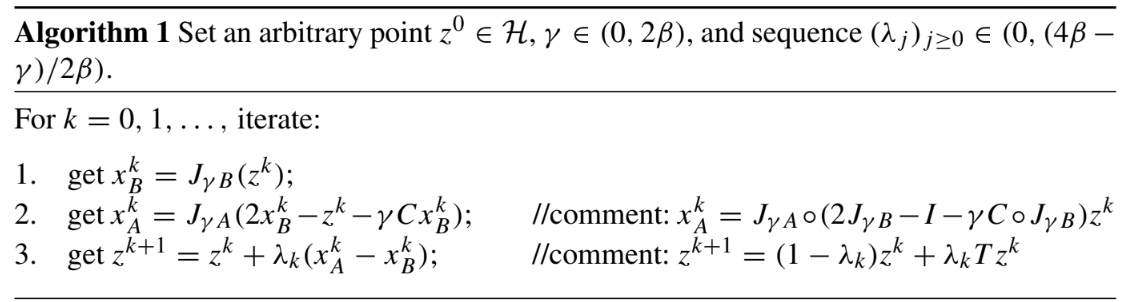

Nuestro objetivo será implementar el algoritmo de davis-yin c:

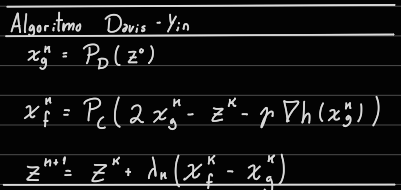

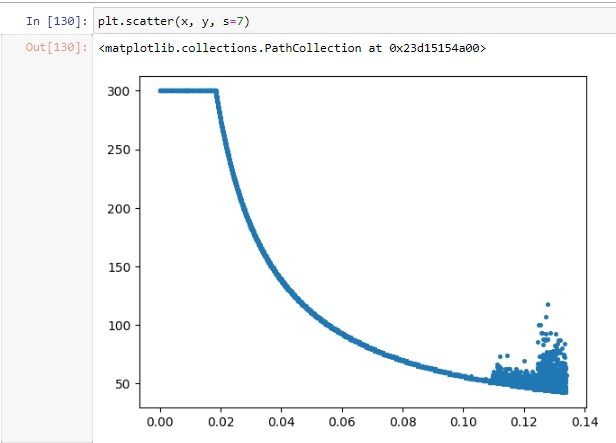

In [276]:
def Davis_Yin_iteration(z1 : np.array, z2: np.array, z3: np.array, gradient_of_h, gamma, lambda_k, Demanda = D):
    """
        Input:
            - z1: np.array(1xN)   decision variable
            - z2: np.array(NxM)   decision variable
            - z3: np.array(Mx1)   decision variable
            - gradient_of_h: function has contain the gradien of the cost function
            - lambda_k: number between 0 and (4*beta - gamma)/(2*beta) where beta is 
                        the lipschitz constan of the gradien of h.
        Output:
            - tuple np.array, np.array, np.array
        Work:
            The function ompute one iteration over the Davis_Yin_algorithm
            with prior knowledge of gamma.
    """
    
    xg_1, xg_2 = pro.P_D(z1, z2)
    xg_3 = z3
    
    grad_x1, grad_x2, grad_x3 = gradient_of_h(xg_1, xg_2, xg_3)
    
    xf_1       =                 2*xg_1 - z1 - gamma*grad_x1
    xf_2, xf_3 = pro.P_C_demanda(2*xg_2 - z2 - gamma*grad_x2,\
                                 2*xg_3 - z3 - gamma*grad_x3  , Demanda) 
    
    #lambda_k = some formula? 
    
    z1 = z1 + lambda_k*(xf_1 - xg_1)
    z2 = z2 + lambda_k*(xf_2 - xg_2)
    z3 = z3 + lambda_k*(xf_3 - xg_3)
    
    return (xg_1, xg_2, xg_3), (xf_1, xf_2, xf_3), (z1, z2, z3)

In [277]:
beta = frobenius_norm_of_MC**(-1)
gamma = 2*beta*np.random.random(1)
lambda_k = ((4*beta-gamma)/(2*beta))*np.random.random(1)

print("Beta:",beta)
print("Gamma:",gamma)
print("Lambda_k:",lambda_k)


#%timeit Davis_Yin_iteration(x1, x2, x3, Grad_Phi, gamma, lambda_k, D)
Davis_Yin_iteration(x1, x2, x3, Grad_Phi, gamma, lambda_k, D)

Beta: 0.06701245178176277
Gamma: [0.06128211]
Lambda_k: [0.45196676]


((array([[5.6],
         [9. ]]),
  array([[5.6, 5.6, 5.6, 5.6, 0. ],
         [4. , 7. , 8. , 1. , 8. ]]),
  array([[9., 9., 7., 2., 9.]])),
 (array([[-3411.63211092],
         [-3666.64949761]]),
  array([[73.079591  , 71.26520642, 60.25047725, 56.36359221, 81.58174255],
         [73.09193172, 74.88757687, 59.79590492, 54.7192195 , 88.51913781]]),
  array([[-19.44146391, -20.26345191, -13.74156348,  43.59418564,
           -7.46963655]])),
 (array([[-1542.47532157],
         [-1652.27139028]]),
  array([[37.49853203, 37.67849052, 27.70019908, 30.94345624, 36.87223576],
         [35.22725644, 37.68292809, 31.41002727, 25.27930153, 44.39197375]]),
  array([[-3.85459626, -4.22610751, -2.37449722, 20.79918927,  1.55627175]])))

In [278]:
def Davis_Yin(N,M, cost_function, beta, number_iteration):
    
    if 1: # Solo para ver cuanto afectaba el punto inicial
        z1     = np.zeros((N, 1))
        z2     = np.zeros((N, M))
        z3     = np.zeros((1, M))

        xg1     = np.zeros((N, 1))
        xg2     = np.zeros((N, M))
        xg3     = np.zeros((1, M))
    
    else:
        
        z1     = 100*np.random.randint(0,10, size=(N, 1))+0.0
        z2     = 100*np.random.randint(0,10, size=(N, M))+0.0
        z3     = 100*np.random.randint(0,10, size=(1, M))+100.0

        xg1    = 100*np.random.randint(0,10, size=(N, 1))+0.0
        xg2    = 100*np.random.randint(0,10, size=(N, M))+0.0
        xg3    = 100*np.random.randint(0,10, size=(1, M))+100.0
    
    # Conclusión: Nada jajajaja
    
    #gamma = 2*beta*np.random.random(1) # gamma in (0, 2*beta*epsilon = 1.0)
    gamma = 2*beta*(0.75 + 0.25*np.random.random(1)) # Uniform distribution - U(2*beta*0.75, 2*beta)
    lambda_k = 1 # lambda_k in (0,(4*beta - gamma)/(2*beta = 1.75))
    
    k=0
    Loss = 1000

    a= "factible"
    b= "factible"
    
    error_list = []
    
    #while k < number_iteration:
    while (Loss >= 1e-6 or ( a == "infactible" or b=="infactible")) and k < number_iteration:
        #lambda_k = ((4*beta - gamma)/(2*beta))*np.random.random(1)
        if k == number_iteration:
            break
            
        (xg1_k, xg2_k, xg3_k), (xf1_k, xf2_k, xf3_k), (z1_k, z2_k, z3_k) = Davis_Yin_iteration(z1, z2, z3, cost_function, gamma, lambda_k)
        
        Loss = (LA.norm(xg1_k - xg1)**2 + LA.norm(xg2_k - xg2)**2 + LA.norm(xg3_k - xg3)**2)**(0.5)
        Loss = Loss/(LA.norm(xg1_k)**2 + LA.norm(xg2_k)**2 + LA.norm(xg3_k)**2)
        
        error_list.append(Loss)
        
        xg1 = xg1_k
        xg2 = xg2_k
        xg3 = xg3_k
        
        z1  = z1_k
        z2  = z2_k
        z3  = z3_k
        
        if (xg1 <= xg2).all():
            a = "factible"
        else:
            a= "infactible"
            
        if (xg2.sum(axis=0) + xg3 >= D).all():
            b = "factible"
        else:
            b= "infactible"

        print("D-Y :: Iteration:",k ," Loss:", Loss, "Factible:",a,b)
        if k > number_iteration*0.999:
            print((xg1_k, xg2_k, xg3_k))
            print()
        
        k+=1
    return (xg1_k, xg2_k, xg3_k), (xf1_k, xf2_k, xf3_k), (z1, z2, z3), error_list
    #return gamma[0], k

In [279]:
(xg1_k, xg2_k, xg3_k), (xf1_k, xf2_k, xf3_k), (z1, z2, z3), error_list_DY = Davis_Yin(N,M, Grad_Phi, beta, 3e2)

D-Y :: Iteration: 0  Loss: nan Factible: factible infactible
D-Y :: Iteration: 1  Loss: 0.00024342624044298023 Factible: infactible infactible
D-Y :: Iteration: 2  Loss: 0.0005402323240224153 Factible: infactible infactible
D-Y :: Iteration: 3  Loss: 6.727174028213897e-05 Factible: infactible infactible
D-Y :: Iteration: 4  Loss: 3.0891198698326907e-06 Factible: infactible factible
D-Y :: Iteration: 5  Loss: 1.6327174149227495e-07 Factible: factible infactible
D-Y :: Iteration: 6  Loss: 7.922326340569665e-09 Factible: infactible factible
D-Y :: Iteration: 7  Loss: 4.184982231228429e-10 Factible: factible infactible
D-Y :: Iteration: 8  Loss: 2.0316494726401573e-11 Factible: infactible factible
D-Y :: Iteration: 9  Loss: 1.073212073374804e-12 Factible: factible infactible
D-Y :: Iteration: 10  Loss: 5.2100944453666656e-14 Factible: infactible factible
D-Y :: Iteration: 11  Loss: 2.7521924155894205e-15 Factible: factible infactible
D-Y :: Iteration: 12  Loss: 1.336110591584253e-16 Factib

C:\Users\alana\AppData\Local\Temp\ipykernel_16364\1121426217.py:45: RuntimeWarning: invalid value encountered in scalar divide
  Loss = Loss/(LA.norm(xg1_k)**2 + LA.norm(xg2_k)**2 + LA.norm(xg3_k)**2)
C:\Users\alana\AppData\Local\Temp\ipykernel_16364\3632573839.py:61: RuntimeWarning: overflow encountered in multiply
  return Q_3*x3+B_3
C:\Users\alana\OneDrive - Universidad Técnica Federico Santa María\Universidad\Memoria\Codigos\proyecciones.py:55: RuntimeWarning: invalid value encountered in add
  x3 = x3_barra + scale_factor * diff


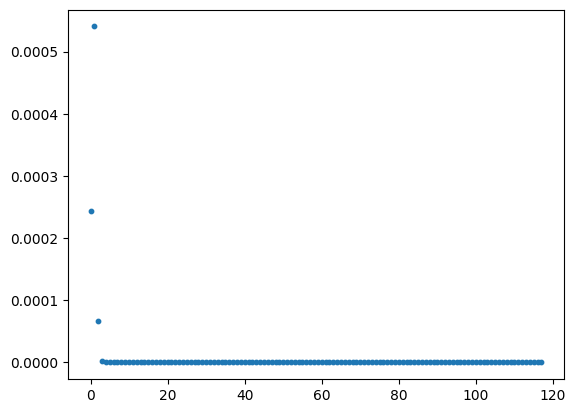

In [280]:
plt.scatter(range(len(error_list_DY)-1), error_list_DY[1:], s=10)
plt.show()

In [281]:
print(xg1_k, xg2_k, xg3_k)
print()
print(xf1_k, xf2_k, xf3_k)
print()
print(z1, z2, z3)

[[nan]
 [nan]] [[nan nan nan nan nan]
 [nan nan nan nan nan]] [[nan nan nan nan nan]]

[[nan]
 [nan]] [[nan nan nan nan nan]
 [nan nan nan nan nan]] [[nan nan nan nan nan]]

[[nan]
 [nan]] [[nan nan nan nan nan]
 [nan nan nan nan nan]] [[nan nan nan nan nan]]


# ADMM

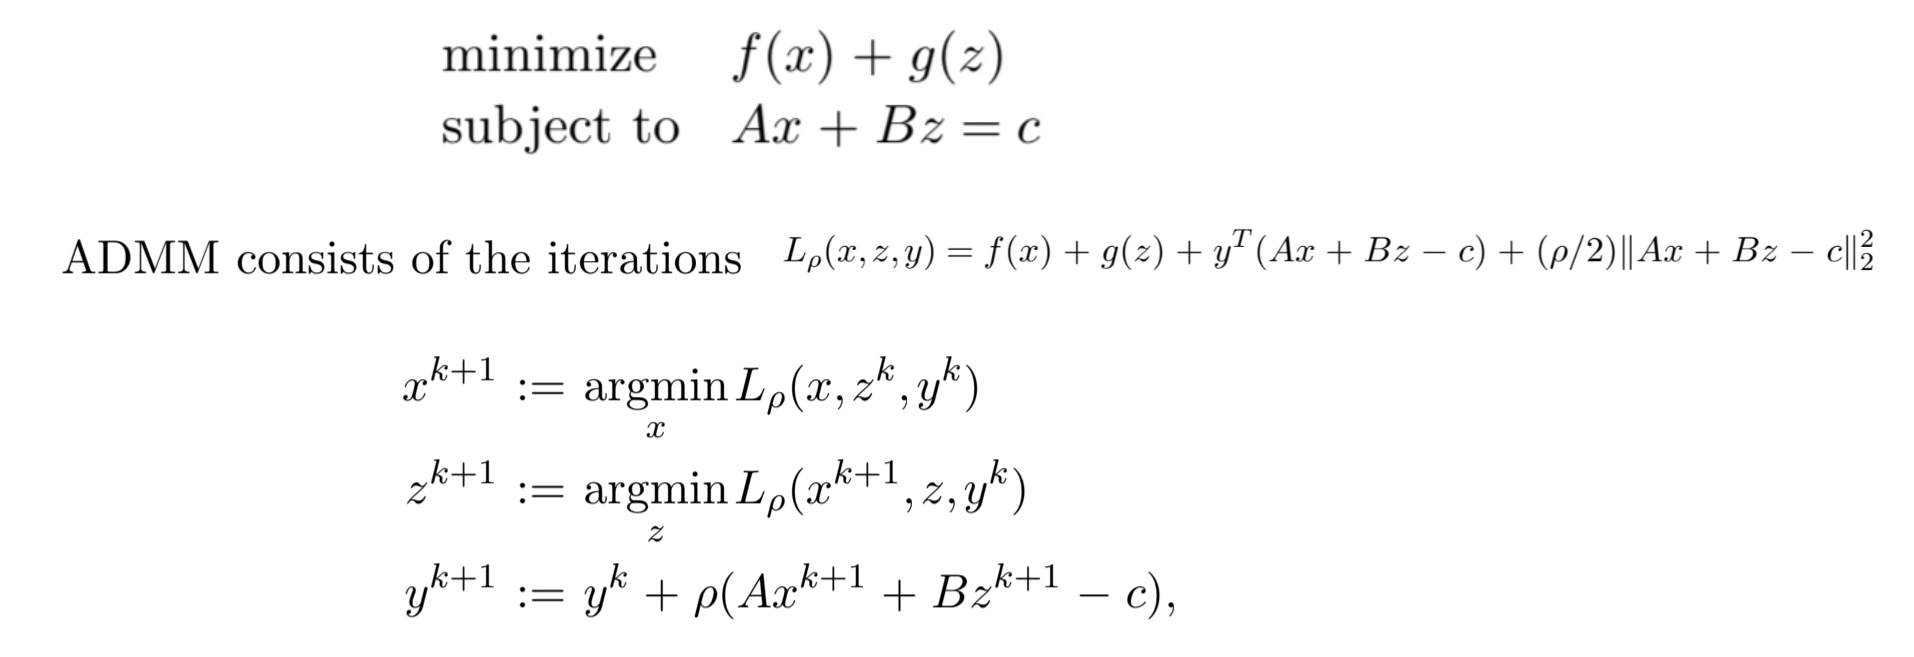

Ahora, estro objetivo será implementar el algoritmo ADMM, esto es:

In [7]:
def inversa_matriz_x2(a, N):
    return ((a**2+(N-2)*a-(N-1))**-1)*((a+N-2+1)*np.identity(N)-np.ones(N))

In [8]:
def ADMM_iteration(decision, state, dual, phi_z1, phi_z2, phi_z3, P, s=1e-3,t=1e-3,r=1e-3):
    """
        Input:
            - decision = (x1,x2,x3): (np.array(NxM), np.array(NxM), np.array(Mx1) decision variable
            - state    = (z1, z2): (np.array(Mx1), np.array(NxM)) state variables
            - dual     = (lambda_1, lambda_2, lambda_3) (np.array(NxM), np.array(NxM), np.array(Mx1)) dual update variable
            
              Now will go the gradient of the objective functions, in this case we
              will assume there are linear, so their value is fix and a vector.
              
            - phi_z1: np.array(N) function has contain the gradient of the cost function over z1 variable 
            - phi_z2: np.array(NxM) function has contain the gradient of the cost function over z2 variable
            - phi_z3: np.array(M) function has contain the gradient of the cost function over zm3 variable
            
            - prob: np.array(M) np.array that contain the probability of each scenario
            
            - s,t,r: floats that are the augmented term of lagrangian. 1e-3 by default.
        Output:
            - tuple np.array, np.array, np.array
        Work:
            The function compute one iteration over the Davis_Yin_algorithm
            with prior knowledge of gamma.
    """
    x1, x2, x3                   = decision
    z1, z2                       = state       #Unpackage the variables
    lambda_1, lambda_2, lambda_3 = dual
    
    N, M = x1.shape
    
    scale_factor_1 = (s+t) ** -1
    scale_factor_2 = np.einsum('i,ijk -> ijk', P/r, np.apply_along_axis(lambda x: inversa_matriz_x2(x, N), 1, (1-P*t/r)[:, None]))
    scale_factor_3 = P/r

    diff_1 = -0.5*(x1 - x2) + z2 - lambda_3
    diff_2 =  0.5*(x2.sum(axis=0) - x3) - z1 + lambda_1
    
    # Start algorithm
    x1_k = scale_factor_1*( -np.tile(phi_z1, (1,M)) + s*(pro.P_N(x1, P) - lambda_2) + t*(x1 + diff_1))
    x2_k = np.squeeze(scale_factor_2@((- phi_z2 - (r/P)*np.tile(-x2.sum(axis=0) + diff_2, (N,1)) - t*(x2 - diff_1) ).T)[:,:,None]).T
    x3_k = scale_factor_3*(  phi_z3 + (r/P)*(x3 + diff_2))
    
    z1_k = np.maximum( 0.5*(x2_k.sum(axis=0) - x3_k) + lambda_1 ,0)
    z2_k = np.maximum( 0.5*(x1_k - x2_k)   + lambda_3 ,0)
    
    lambda_1_k = (lambda_1 + 0.5*(x2_k.sum(axis=0) - x3_k) - z1_k)
    lambda_2_k = -(lambda_2 + x1_k - pro.P_N(x1_k, P))
    lambda_3_k = (lambda_3 - 0.5*(x2 - x1) - z2_k)
    
    return (x1_k, x2_k, x3_k), (z1_k, z2_k), (lambda_1_k, lambda_2_k, lambda_3_k)

In [9]:
N, M = 3, 3

x1  = np.random.randint(0,10, size=(N, M))+0.0
x2  = np.random.randint(0,10, size=(N, M))+0.0
x3  = np.random.randint(0,10, size=(1, M))+5.0

proba  = np.random.rand(M)  
proba /= proba.sum()  

gradient_of_h = np.random.randint(0,10, size=(N, 1))+0.0,\
                np.random.randint(0,10, size=(N, M))+0.0,\
                np.random.randint(0,10, size=(1, M))+5.0
    
phi_1, phi_2, phi_3 = gradient_of_h


z1 = np.random.randint(0,10, size=(1, M))
z2 = np.random.randint(0,10, size=(N, M))

lambda_1 = np.random.randint(0,10, size=(1, M))
lambda_2 = np.random.randint(0,10, size=(N, M))
lambda_3 = np.random.randint(0,10, size=(N, M))


%timeit ADMM_iteration((x1, x2, x3), (z1, z2), (lambda_1, lambda_2, lambda_3), phi_1, phi_2, phi_3, proba)
ADMM_iteration((x1, x2, x3), (z1, z2), (lambda_1, lambda_2, lambda_3), phi_1, phi_2, phi_3, proba)

301 µs ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


((array([[-4.49486885e+03, -4.49861885e+03, -4.49911885e+03],
         [ 3.65080553e+00,  6.40080553e+00, -3.59919447e+00],
         [-4.95114428e+02, -4.99614428e+02, -4.96114428e+02]]),
  array([[-5241.32103394, -3389.43443695,  2171.90038044],
         [ 1761.67896606,  -393.43443695, -4822.09961956],
         [ 2763.17896606,  2613.56556305,   170.90038044]]),
  array([[1257.54276542, 4518.67790187, 6191.70183925]])),
 (array([[0., 0., 0.]]),
  array([[ 373.22609217,    0.        ,    0.        ],
         [   0.        ,  201.91762124, 2416.25021255],
         [   0.        ,    0.        ,    0.        ]])),
 (array([[ -980.00293362, -2839.99060635, -4330.50034897]]),
  array([[ -8.48813642,  -7.73813642,  -3.23813642],
         [ -3.78147293, -11.53147293,  -2.53147293],
         [ -9.07402391,  -3.57402391,  -5.07402391]]),
  array([[-3.77726092e+02,  0.00000000e+00, -1.00000000e+00],
         [ 5.50000000e+00, -1.98917621e+02, -2.40825021e+03],
         [ 5.00000000e+00,  1.10

In [43]:
def ADMM(initial_point, gradient, proba):
    
    x1, x2, x3 = initial_point
    
    phi_1, phi_2, phi_3 = gradient
    
    N, M = x2.shape

    z1 = np.zeros((1, M))
    z2 = np.zeros((N, M))

    lambda_1 = np.zeros((1, M))
    lambda_2 = np.zeros((N, M))
    lambda_3 = np.zeros((N, M))
    
    s=1e3
    t=1e3
    r=1e3
    
    k=0
    Loss = 1000
    
    a= "factible"
    b= "factible"
    
    error_list = []
    
    while Loss >= 1e-6 and k <1000:#(a == "factible" or b=="factible"):
        
        (x1_k, x2_k, x3_k), (z1_k, z2_k), (lambda_1_k, lambda_2_k, lambda_3_k) = ADMM_iteration((x1, x2, x3), (z1, z2), (lambda_1, lambda_2, lambda_3), phi_1, phi_2, phi_3, proba, s, t, r)
        
        Loss = LA.norm(x1_k - x1)**2 + LA.norm(x2_k - x2)**2 + LA.norm(x3_k - x3)**2
        Loss = Loss/(LA.norm(x1_k)**2 + LA.norm(x2_k)**2 + LA.norm(x3_k)**2)*100
        
        error_list.append(Loss)
        
        a= "infactible"
        b= "infactible"
        
        if (x2_k <= x1_k).all():
            a = "factible"
        if (x2_k.sum(axis=0) >= x3_k).all():
            b = "factible"

        print("Iteration:",k ," Loss:", Loss, "Factible:",a,b)
        
        x1, x2, x3 = x1_k, x2_k, x3_k
        z1, z2 = z1_k, z2_k
        lambda_1, lambda_2, lambda_3 = lambda_1_k, lambda_2_k, lambda_3_k
        
        k+=1
        
    return (x1, x2, x3), (z1, z2), (lambda_1, lambda_2, lambda_3), error_list

In [11]:
N, M = 3, 5

z1_0   = np.random.randint(0,10, size=(N, M))+0.0
z2_0   = np.random.randint(0,10, size=(N, M))+0.0
z3_0   = np.random.randint(0,10, size=(1, M))+0.0

proba  = np.random.rand(M)  
proba /= proba.sum()  

gradient_of_h = np.random.randint(0,10, size=(N, 1))+0.0,\
                np.random.randint(0,10, size=(N, M))+0.0,\
                np.random.randint(0,10, size=(1, M))+5.0


(x1, x2, x3), (z1, z2), (lambda_1, lambda_2, lambda_3), error_list_ADMM = ADMM((z1_0,z2_0,z3_0), gradient_of_h, proba)

Iteration: 0  Loss: 24.586244236048532 Factible: infactible infactible
Iteration: 1  Loss: 2.500252670609975 Factible: infactible factible
Iteration: 2  Loss: 0.7688904719069198 Factible: infactible factible
Iteration: 3  Loss: 1.8708385019476141 Factible: infactible factible
Iteration: 4  Loss: 1.7244630786895114 Factible: infactible factible
Iteration: 5  Loss: 0.559711440088917 Factible: infactible factible
Iteration: 6  Loss: 1.0877294803380406 Factible: infactible factible
Iteration: 7  Loss: 0.7078062884810523 Factible: infactible factible
Iteration: 8  Loss: 0.35792951549697605 Factible: infactible factible
Iteration: 9  Loss: 0.6464304128078042 Factible: infactible factible
Iteration: 10  Loss: 0.33302470768631093 Factible: infactible factible
Iteration: 11  Loss: 0.3018707744959807 Factible: infactible factible
Iteration: 12  Loss: 0.381092900265642 Factible: infactible factible
Iteration: 13  Loss: 0.15067039896982906 Factible: infactible factible
Iteration: 14  Loss: 0.22430

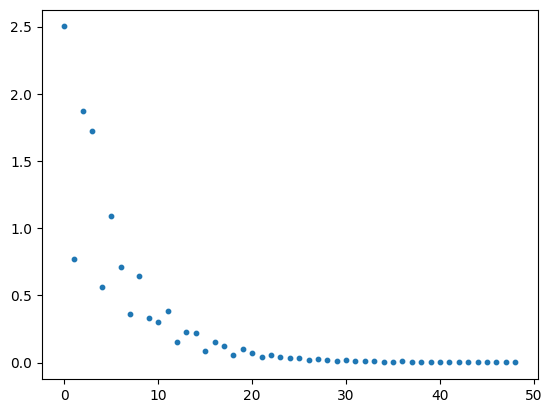

In [12]:
plt.scatter(range(len(error_list_ADMM)-1), error_list_ADMM[1:], s=10)
plt.show()

In [46]:
N, M = 3, 5

x1   = np.random.randint(0,10, size=(N, M))+0.0
x2   = np.random.randint(0,10, size=(N, M))+0.0
x3   = np.random.randint(0,10, size=(1, M))+0.0

gradient_of_h = -np.random.randint(0,10, size=(N, 1))+0.0,\
                -np.random.randint(0,10, size=(N, M))+0.0,\
                -np.random.randint(0,10, size=(1, M))+5.0
        
gamma = 1
lambda_k = 1

#%timeit Davis_Yin_iteration(x1, x2, x3, gradient_of_h, gamma, lambda_k) 
(xg1, xg2, xg3), (xf1, xf2, xf3), (z1, z2, z3), error_list_DY = Davis_Yin((x1, x2, x3), gradient_of_h)

print("Bandera")

proba  = np.random.rand(M)  
proba /= proba.sum()  


(x1, x2, x3), (z1, z2), (lambda_1, lambda_2, lambda_3), error_list_ADMM = ADMM((x1,x2,x3), gradient_of_h, proba)

D-Y :: Iteration: 0  Loss: 100.0 Factible: factible factible
D-Y :: Iteration: 1  Loss: 11.59133541083583 Factible: factible factible
D-Y :: Iteration: 2  Loss: 6.704769375038808 Factible: factible factible
D-Y :: Iteration: 3  Loss: 4.3099029604474834 Factible: factible factible
D-Y :: Iteration: 4  Loss: 3.083841083082741 Factible: factible factible
D-Y :: Iteration: 5  Loss: 2.2439225976591546 Factible: factible factible
D-Y :: Iteration: 6  Loss: 1.703503754735355 Factible: factible factible
D-Y :: Iteration: 7  Loss: 1.3361791073861282 Factible: factible factible
D-Y :: Iteration: 8  Loss: 1.0722852818043205 Factible: factible factible
D-Y :: Iteration: 9  Loss: 0.8970112751108092 Factible: factible factible
D-Y :: Iteration: 10  Loss: 0.7492768933012738 Factible: factible factible
D-Y :: Iteration: 11  Loss: 0.6351517070845499 Factible: factible factible
D-Y :: Iteration: 12  Loss: 0.5451867358563095 Factible: factible factible
D-Y :: Iteration: 13  Loss: 0.4730277626778276 Facti

D-Y :: Iteration: 1355  Loss: 5.43458326830302e-05 Factible: factible factible
D-Y :: Iteration: 1356  Loss: 5.426579414195452e-05 Factible: factible factible
D-Y :: Iteration: 1357  Loss: 5.418593228744016e-05 Factible: factible factible
D-Y :: Iteration: 1358  Loss: 5.4106246599817863e-05 Factible: factible factible
D-Y :: Iteration: 1359  Loss: 5.402673656132751e-05 Factible: factible factible
D-Y :: Iteration: 1360  Loss: 5.394740165610974e-05 Factible: factible factible
D-Y :: Iteration: 1361  Loss: 5.386824137019762e-05 Factible: factible factible
D-Y :: Iteration: 1362  Loss: 5.378925519150817e-05 Factible: factible factible
D-Y :: Iteration: 1363  Loss: 5.371044260983328e-05 Factible: factible factible
D-Y :: Iteration: 1364  Loss: 5.36318031168353e-05 Factible: factible factible
D-Y :: Iteration: 1365  Loss: 5.355333620603293e-05 Factible: factible factible
D-Y :: Iteration: 1366  Loss: 5.347504137279662e-05 Factible: factible factible
D-Y :: Iteration: 1367  Loss: 5.339691811

D-Y :: Iteration: 2531  Loss: 1.5592089038115404e-05 Factible: factible factible
D-Y :: Iteration: 2532  Loss: 1.557978268898062e-05 Factible: factible factible
D-Y :: Iteration: 2533  Loss: 1.5567490903623e-05 Factible: factible factible
D-Y :: Iteration: 2534  Loss: 1.55552136590712e-05 Factible: factible factible
D-Y :: Iteration: 2535  Loss: 1.5542950932399167e-05 Factible: factible factible
D-Y :: Iteration: 2536  Loss: 1.5530702700726002e-05 Factible: factible factible
D-Y :: Iteration: 2537  Loss: 1.5518468941215865e-05 Factible: factible factible
D-Y :: Iteration: 2538  Loss: 1.5506249631077887e-05 Factible: factible factible
D-Y :: Iteration: 2539  Loss: 1.5494044747566002e-05 Factible: factible factible
D-Y :: Iteration: 2540  Loss: 1.5481854267978936e-05 Factible: factible factible
D-Y :: Iteration: 2541  Loss: 1.546967816966002e-05 Factible: factible factible
D-Y :: Iteration: 2542  Loss: 1.545751642999712e-05 Factible: factible factible
D-Y :: Iteration: 2543  Loss: 1.5445

D-Y :: Iteration: 3978  Loss: 6.314588435039931e-06 Factible: factible factible
D-Y :: Iteration: 3979  Loss: 6.311416064742078e-06 Factible: factible factible
D-Y :: Iteration: 3980  Loss: 6.3082460844825495e-06 Factible: factible factible
D-Y :: Iteration: 3981  Loss: 6.3050784918611056e-06 Factible: factible factible
D-Y :: Iteration: 3982  Loss: 6.301913284480511e-06 Factible: factible factible
D-Y :: Iteration: 3983  Loss: 6.298750459946544e-06 Factible: factible factible
D-Y :: Iteration: 3984  Loss: 6.2955900158679794e-06 Factible: factible factible
D-Y :: Iteration: 3985  Loss: 6.292431949856599e-06 Factible: factible factible
D-Y :: Iteration: 3986  Loss: 6.289276259527172e-06 Factible: factible factible
D-Y :: Iteration: 3987  Loss: 6.286122942497461e-06 Factible: factible factible
D-Y :: Iteration: 3988  Loss: 6.2829719963882124e-06 Factible: factible factible
D-Y :: Iteration: 3989  Loss: 6.279823418823152e-06 Factible: factible factible
D-Y :: Iteration: 3990  Loss: 6.2766

D-Y :: Iteration: 5760  Loss: 3.0125225349322192e-06 Factible: factible factible
D-Y :: Iteration: 5761  Loss: 3.011477062980472e-06 Factible: factible factible
D-Y :: Iteration: 5762  Loss: 3.0104321351683654e-06 Factible: factible factible
D-Y :: Iteration: 5763  Loss: 3.009387751118354e-06 Factible: factible factible
D-Y :: Iteration: 5764  Loss: 3.008343910453216e-06 Factible: factible factible
D-Y :: Iteration: 5765  Loss: 3.0073006127960603e-06 Factible: factible factible
D-Y :: Iteration: 5766  Loss: 3.006257857770318e-06 Factible: factible factible
D-Y :: Iteration: 5767  Loss: 3.0052156449997505e-06 Factible: factible factible
D-Y :: Iteration: 5768  Loss: 3.0041739741084425e-06 Factible: factible factible
D-Y :: Iteration: 5769  Loss: 3.0031328447208083e-06 Factible: factible factible
D-Y :: Iteration: 5770  Loss: 3.002092256461582e-06 Factible: factible factible
D-Y :: Iteration: 5771  Loss: 3.0010522089558274e-06 Factible: factible factible
D-Y :: Iteration: 5772  Loss: 3.0

D-Y :: Iteration: 7305  Loss: 1.8731922780801059e-06 Factible: factible factible
D-Y :: Iteration: 7306  Loss: 1.8726796358541385e-06 Factible: factible factible
D-Y :: Iteration: 7307  Loss: 1.8721672040439115e-06 Factible: factible factible
D-Y :: Iteration: 7308  Loss: 1.8716549825342861e-06 Factible: factible factible
D-Y :: Iteration: 7309  Loss: 1.8711429712102023e-06 Factible: factible factible
D-Y :: Iteration: 7310  Loss: 1.8706311699566782e-06 Factible: factible factible
D-Y :: Iteration: 7311  Loss: 1.8701195786588112e-06 Factible: factible factible
D-Y :: Iteration: 7312  Loss: 1.8696081972017783e-06 Factible: factible factible
D-Y :: Iteration: 7313  Loss: 1.8690970254708336e-06 Factible: factible factible
D-Y :: Iteration: 7314  Loss: 1.8685860633513081e-06 Factible: factible factible
D-Y :: Iteration: 7315  Loss: 1.8680753107286147e-06 Factible: factible factible
D-Y :: Iteration: 7316  Loss: 1.8675647674882428e-06 Factible: factible factible
D-Y :: Iteration: 7317  Loss

D-Y :: Iteration: 8761  Loss: 1.3024014976845448e-06 Factible: factible factible
D-Y :: Iteration: 8762  Loss: 1.3021042811387029e-06 Factible: factible factible
D-Y :: Iteration: 8763  Loss: 1.3018071663213943e-06 Factible: factible factible
D-Y :: Iteration: 8764  Loss: 1.3015101531861993e-06 Factible: factible factible
D-Y :: Iteration: 8765  Loss: 1.3012132416867245e-06 Factible: factible factible
D-Y :: Iteration: 8766  Loss: 1.3009164317766037e-06 Factible: factible factible
D-Y :: Iteration: 8767  Loss: 1.3006197234094963e-06 Factible: factible factible
D-Y :: Iteration: 8768  Loss: 1.3003231165390883e-06 Factible: factible factible
D-Y :: Iteration: 8769  Loss: 1.3000266111190923e-06 Factible: factible factible
D-Y :: Iteration: 8770  Loss: 1.2997302071032476e-06 Factible: factible factible
D-Y :: Iteration: 8771  Loss: 1.299433904445319e-06 Factible: factible factible
D-Y :: Iteration: 8772  Loss: 1.2991377030990989e-06 Factible: factible factible
D-Y :: Iteration: 8773  Loss:

Iteration: 139  Loss: 2.229510792484039e-05 Factible: factible factible
Iteration: 140  Loss: 2.2285167675798682e-05 Factible: factible factible
Iteration: 141  Loss: 2.222823318874436e-05 Factible: factible factible
Iteration: 142  Loss: 2.2204300285845593e-05 Factible: factible factible
Iteration: 143  Loss: 2.219822704468483e-05 Factible: factible factible
Iteration: 144  Loss: 2.2202360576349298e-05 Factible: factible factible
Iteration: 145  Loss: 2.220938930910923e-05 Factible: factible factible
Iteration: 146  Loss: 2.218081413203923e-05 Factible: factible factible
Iteration: 147  Loss: 2.2145995385198947e-05 Factible: factible factible
Iteration: 148  Loss: 2.2132064409717107e-05 Factible: factible factible
Iteration: 149  Loss: 2.212740537597469e-05 Factible: factible factible
Iteration: 150  Loss: 2.2129917213183708e-05 Factible: factible factible
Iteration: 151  Loss: 2.2120298053440308e-05 Factible: factible factible
Iteration: 152  Loss: 2.2092443951283553e-05 Factible: fa

Iteration: 371  Loss: 1.944351931676168e-05 Factible: factible factible
Iteration: 372  Loss: 1.94320503850522e-05 Factible: factible factible
Iteration: 373  Loss: 1.942058743192188e-05 Factible: factible factible
Iteration: 374  Loss: 1.9409130459280365e-05 Factible: factible factible
Iteration: 375  Loss: 1.939767947026389e-05 Factible: factible factible
Iteration: 376  Loss: 1.9386234469061426e-05 Factible: factible factible
Iteration: 377  Loss: 1.9374795458732576e-05 Factible: factible factible
Iteration: 378  Loss: 1.9363362441520038e-05 Factible: factible factible
Iteration: 379  Loss: 1.935193541891236e-05 Factible: factible factible
Iteration: 380  Loss: 1.9340514393499524e-05 Factible: factible factible
Iteration: 381  Loss: 1.9329099368378e-05 Factible: factible factible
Iteration: 382  Loss: 1.9317690347154135e-05 Factible: factible factible
Iteration: 383  Loss: 1.9306287332218305e-05 Factible: factible factible
Iteration: 384  Loss: 1.9294890325666377e-05 Factible: facti

Iteration: 740  Loss: 1.5627462617222238e-05 Factible: factible factible
Iteration: 741  Loss: 1.561825251006969e-05 Factible: factible factible
Iteration: 742  Loss: 1.5609048379809354e-05 Factible: factible factible
Iteration: 743  Loss: 1.5599850224269546e-05 Factible: factible factible
Iteration: 744  Loss: 1.559065804177531e-05 Factible: factible factible
Iteration: 745  Loss: 1.5581471830087664e-05 Factible: factible factible
Iteration: 746  Loss: 1.5572291587435173e-05 Factible: factible factible
Iteration: 747  Loss: 1.5563117311645637e-05 Factible: factible factible
Iteration: 748  Loss: 1.5553949001010745e-05 Factible: factible factible
Iteration: 749  Loss: 1.5544786653316897e-05 Factible: factible factible
Iteration: 750  Loss: 1.5535630266731745e-05 Factible: factible factible
Iteration: 751  Loss: 1.552647983908831e-05 Factible: factible factible
Iteration: 752  Loss: 1.5517335368555494e-05 Factible: factible factible
Iteration: 753  Loss: 1.5508196852995433e-05 Factible:

In [47]:
print(xg1)
print(x1)

[[40000.66666667 40007.66666667 40002.66666667 40005.66666667
  40006.66666667]
 [29997.48       30005.48       29998.48       29996.48
  30001.48      ]
 [35003.5        34999.5        35002.5        35003.5
  35001.5       ]]
[[9.61315946 9.61315946 9.61315946 9.61315946 9.61315946]
 [3.90705773 3.90705773 3.90705773 3.90705773 3.90705773]
 [8.16742514 8.16742514 8.16742514 8.16742514 8.16742514]]


# Briceno_Arias

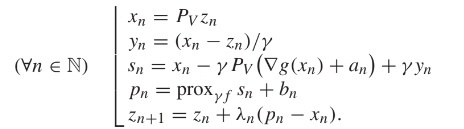

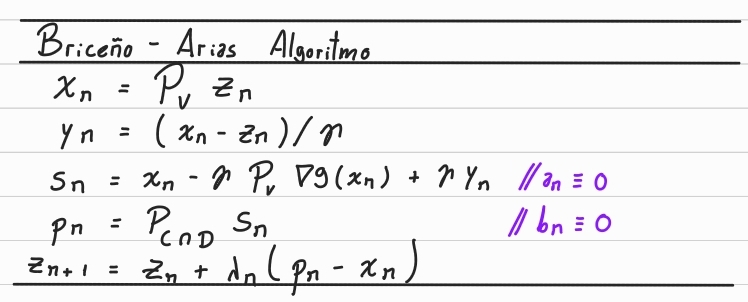

In [13]:
def Briceno_Arias_iteration(z1, z2, z2_copy, z3, gradient_of_g, P, gamma, lambdan):
    """
        Input:
            - z1: np.array(1xN)   decision variable
            - z2: np.array(NxM) decision variable
            - z3: np.array(Mx1)   decision variable
            - gradient_of_g: function has contain the gradien of the cost function
            - lambda_k: number between 0 and (4*beta - gamma)/(2*beta) where beta is 
                        the lipschitz constan of the gradien of h.
        Output:
            - tuple np.array, np.array, np.array
        Work:
            The function ompute one iteration over the Davis_Yin_algorithm
            with prior knowledge of gamma.
    """
    # Unpackage of gradient
    g1, g2, g3 = gradient_of_g
    
    # First step, xn = Pv zn
    x1, x2, x2_copy = pro.P_N1(z1, z2, z2_copy, P)
    x3 = z3
    
    # Segundo step, yn = (xn-zn)/gamma
    y1, y2, y2_copy, y3 = (x1-z1)*(gamma**-1), (x2-z2)*(gamma**-1), (x2_copy-z2_copy)*(gamma**-1), (x3-z3)*(gamma**-1)
    
    # Third step, sn = xn - gamma * Pv ( gradient_of_g ) + gamma * yn
    (s1_aux, s2_aux, s2_copy_aux) = pro.P_N1(np.tile(g1,(1,M)), g2, g2, P)

    s1, s2, s2_copy, s3 = x1 - gamma*(s1_aux - y1), \
                          x2 - gamma*(s2_aux - y2), \
                          x2_copy - gamma*(s2_copy_aux - y2_copy), \
                          x3 - gamma*(g3 - y3)
    
    # Fourth step, pn = Pc\cap D sn
    print("pro.P_CinterD(s1, s2, s2_copy, s3)")
    (p1, p2),( p2_copy, p3) = pro.P_CinterD(s1, s2, s2_copy, s3)
    
    if (p2 <= p1).all():
        print("factible C")
    if (p2_copy >= p3).all():
        print("factible D")
    

    
    # Last step, zn+1 = zn + lambdan* (pn - xn)
    z1n, z2n, z2_copyn, z3n = z1 + lambdan * (p1 - x1), \
                              z2 + lambdan * (p2 - x2), \
                              z2_copy + lambdan * (p2_copy - x2_copy), \
                              z3 + lambdan * (p3 - x3), \
    
    #return (x1, x2, x2_copy, x3), (y1, y2, y2_copy, y3), (z1n, z2n, z2_copyn, z3n)
    return (z1n, z2n, z2_copyn, z3n)

In [16]:
N, M = 4, 5

z1_0   = np.random.randint(0,10, size=(N, M))+0.0
z2_0   = np.random.randint(0,10, size=(N, M))+0.0
z2_copy_0   = np.random.randint(0,10, size=(N, M))+0.0
z3_0   = np.random.randint(0,10, size=(1, M))+5.0

gradient_of_g = np.random.randint(0,10, size=(N, 1))+0.0,\
                np.random.randint(0,10, size=(N, M))+0.0,\
                np.random.randint(0,10, size=(1, M))+0.0


proba  = np.random.rand(M)  
proba /= proba.sum()  

#%timeit Briceno_Arias_iteration(z1_0,z2_0,z2_copy_0, z3_0, gradient_of_g, proba, 1e-3, 1e-3)
Briceno_Arias_iteration(z1_0,z2_0,z2_copy_0, z3_0, gradient_of_g, proba, 1e-3, 1e-3)

pro.P_CinterD(s1, s2, s2_copy, s3)


(array([[1.00349600e+00, 2.00183825e+00, 4.00199750e+00, 7.99899800e+00,
         6.99749600e+00],
        [2.99350000e-03, 4.99949350e+00, 3.99150000e-03, 6.99699400e+00,
         2.99976162e+00],
        [6.00049350e+00, 6.99812730e+00, 3.00212730e+00, 4.00112730e+00,
         5.99912730e+00],
        [5.99924986e+00, 7.99899800e+00, 5.00149650e+00, 1.00424986e+00,
         1.00424986e+00]]),
 array([[3.00183725e+00, 5.99899700e+00, 5.99883875e+00, 6.99633925e+00,
         4.99783725e+00],
        [2.76412460e-03, 1.99926412e+00, 6.99926212e+00, 9.98764625e-01,
         6.99699200e+00],
        [4.99962480e+00, 2.99999700e+00, 2.99849200e+00, 7.99649600e+00,
         5.99899700e+00],
        [2.99999100e+00, 7.99725186e+00, 1.00225036e+00, 1.00099800e+00,
         7.00099500e+00]]),
 array([[7.997495e+00, 4.000997e+00, 7.998998e+00, 6.000499e+00,
         2.001495e+00],
        [5.996996e+00, 3.998996e+00, 7.999492e+00, 9.999970e-01,
         1.002992e+00],
        [6.998991e+00, 2.9

In [17]:
def Briceno_Arias(initial_point, gradient_of_g, P, gamma=1e-3, lambdan=1e-3):

    z1, z2, z2_copy, z3 = initial_point
    
    N, M = z2.shape

    k=0
    Loss = 1000
    
    # Briceno_Arias_iteration(z1, z2, z2_copy, z3, gradient_of_g, P, gamma, lambdan):
    # (x1, x2, x2_copy, x3), (y1, y2, y2_copy, y3), (s1, s2, s2_copy, s3), (p1, p2, p2_copy, p3), (z1n, z2n, z2_copyn, z3n)
    
    x1, x2, x2_copy, x3 = z1, z2, z2_copy, z3
    
    error_list = []
    
    while Loss >= 1e-3 and k < 500:
        
        #(x1_k, x2_k, x2_copy_k, x3_k), (y1_k, y2_k, y2_copy_k, y3_k), (z1n_k, z2n_k, z2_copyn_k, z3n_k) = Briceno_Arias_iteration(x1, x2, x2_copy, x3, gradient_of_g, P, gamma, lambdan)
        x1_k, x2_k, x2_copy_k, x3_k = Briceno_Arias_iteration(x1, x2, x2_copy, x3, gradient_of_g, P, gamma, lambdan)
        
        Loss = LA.norm(x1_k - x1)**2 + LA.norm(x2_k - x2)**2 + LA.norm(x3_k - x3)**2
        Loss = Loss/(LA.norm(x1_k)**2 + LA.norm(x2_k)**2 + LA.norm(x3_k)**2)*100
        
        a= "infactible"
        b= "infactible"
        
        error_list.append(Loss)
        
        if (x2_k <= x1_k).all():
            a = "factible"
        if (x2_copy_k.sum(axis=0) >= x3_k).all():
            b = "factible"

        print("Iteration:",k ," Loss:", Loss, "Factible:",a,b)
        
        x1, x2, x2_copy, x3 = x1_k, x2_k, x2_copy_k, x3_k
        #y1, y2, y2_copy, y3 = y1_k, y2_k, y2_copy_k, y3_k
        
        k+=1
        
    return (x1, x2, x2_copy, x3), (y1, y2, y2_copy, y3), error_list

In [18]:
N, M = 3, 5

z1_0   = np.random.randint(0,10, size=(N, M))+0.0
z2_0   = np.random.randint(0,10, size=(N, M))+0.0
z2_copy_0   = np.random.randint(0,10, size=(N, M))+0.0
z3_0   = np.random.randint(0,10, size=(1, M))+5.0

initial_point = (z1_0, z2_0, z2_copy_0, z3_0)

gradient_of_g = np.random.randint(0,10, size=(N, 1))+0.0,\
                np.random.randint(0,10, size=(N, M))+0.0,\
                np.random.randint(0,10, size=(1, M))+5.0


proba  = np.random.rand(M)  
proba /= proba.sum()  

#%timeit Briceno_Arias_iteration(z1_0,z2_0,z2_copy_0, z3_0, gradient_of_g, proba, 1e-3, 1e-3)
(x1, x2, x2_copy, x3), (y1, y2, y2_copy, y3), error_list_BA = Briceno_Arias(initial_point, gradient_of_g, proba)

pro.P_CinterD(s1, s2, s2_copy, s3)
Iteration: 0  Loss: 1.3796216221634128e-05 Factible: infactible infactible


NameError: name 'y1' is not defined

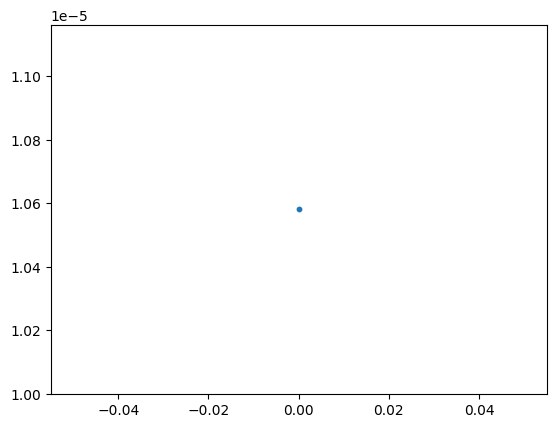

In [79]:
plt.scatter(range(len(error_list_BA)), error_list_BA, s=10)
plt.show()

In [62]:
(x1_admm, x2_admm, x3_admm), (z1_admm, z2_admm), (lambda_1, lambda_2, lambda_3), error_list_ADMM = ADMM((z1_0,z2_0,z3_0), gradient_of_h, proba)

(x1_ba, x2_ba, x2_copy_ba, x3_ba), (y1, y2, y2_copy, y3), error_list_BA = Briceno_Arias(initial_point, gradient_of_g, proba)

Iteration: 0  Loss: 8.682860960204835 Factible: infactible infactible
Iteration: 1  Loss: 2.3302404212160495 Factible: infactible factible
Iteration: 2  Loss: 1.064528039359572 Factible: infactible factible
Iteration: 3  Loss: 1.4579638170947027 Factible: infactible factible
Iteration: 4  Loss: 0.9622125784657324 Factible: infactible factible
Iteration: 5  Loss: 0.5121248343638214 Factible: infactible factible
Iteration: 6  Loss: 0.9852972334863115 Factible: infactible factible
Iteration: 7  Loss: 0.6913947596071454 Factible: infactible factible
Iteration: 8  Loss: 0.3840358869683735 Factible: infactible factible
Iteration: 9  Loss: 0.5436253275754399 Factible: infactible factible
Iteration: 10  Loss: 0.17850847525482677 Factible: infactible factible
Iteration: 11  Loss: 0.2503369423084225 Factible: infactible factible
Iteration: 12  Loss: 0.3201482245435911 Factible: infactible factible
Iteration: 13  Loss: 0.0687218272366931 Factible: infactible factible
Iteration: 14  Loss: 0.214189

In [63]:
x2_admm

array([[4.05050672, 1.50238116, 1.99177421, 4.79428973, 3.55976759],
       [7.48171522, 7.12092038, 2.89871293, 8.40970048, 5.74777619],
       [3.99563261, 3.01702706, 3.52156958, 5.10563412, 1.28779096]])

In [64]:
x2_ba

array([[4.998995  , 1.000996  , 3.99825954, 7.99775754, 4.99675854],
       [6.996993  , 7.997494  , 1.000493  , 8.997998  , 8.998998  ],
       [3.00081721, 2.00081371, 2.99781821, 2.9995    , 0.999491  ]])